# load dataset

In [1]:
!pwd

/pscratch/sd/b/binxia/ml21cm/evaluation


In [2]:
import os, sys
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"sys.path.append(parent_dir): {parent_dir}")
sys.path.append(parent_dir)

from utils.load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
import matplotlib as mpl
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
from scipy.linalg import sqrtm
# print("before torch")
import torch
# print("after torch")
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from kymatio.torch import Scattering2D
import os
import gc
# print("before summary writer")
# from torch.utils.tensorboard import SummaryWriter
# print("after summary writer")
import multiprocessing
import matplotlib.ticker as ticker
from numpy import interp
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import PowerTransformer
import joblib

# print("before spawn")
multiprocessing.set_start_method('spawn', force=True)
# print("after spawn")
print(torch.cuda.is_available())

# ranges_dict = dict(
#     params = {
#         0: [4, 6], # ION_Tvir_MIN
#         1: [10, 250], # HII_EFF_FACTOR
#         },
#     images = {
#         0: [-387, 86], # brightness_temp
#         # 0: [-338, 54], # brightness_temp
#         }
#     )

sys.path.append(parent_dir): /pscratch/sd/b/binxia/ml21cm
True


In [3]:
def load_h5_as_tensor(dir_name='LEN128-DIM64-CUB8.h5', startat=0, scale_path=None):
    # print("dataset = Dataset4h5(")
    dir_name = os.path.join(os.environ['SCRATCH'], dir_name)
    dataset = Dataset4h5(dir_name, num_image=1600, num_redshift=1024, HII_DIM=64, scale_path=scale_path, dim=2, startat=startat)
    print(f"dataset.ranges_dict = {dataset.ranges_dict}")
    # print("with h5py.File(dir_name)")
    with h5py.File(dir_name) as f:
        # print(f.keys())
        # print(f['params'])
        # print(f['redshifts_distances'])
        los = f['redshifts_distances'][:,startat:startat+dataset.num_redshift]

    # print("dataloader = DataLoader(")
    dataloader = DataLoader(dataset, batch_size=800)
    
    # print("x, c = next(iter(dataloader))")
    x, c = next(iter(dataloader))
    # print("x.shape =", x.shape)
    # print("c.shape =", c.shape)
    print("x.min() =", x.min())
    print("x.max() =", x.max())
    return x, c, los

In [4]:
os.environ["SLURM_NODEID"] = '0'
x, c, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir[4, 6]-zeta[10, 250]-0809-123640.h5', scale_path=None)
x_scaled, c_scaled, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir[4, 6]-zeta[10, 250]-0809-123640.h5', scale_path='../utils/power_transformer_25600.pkl')
# x0, c0, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.4-zeta131.341-0812-104709.h5')
# x1, c1, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir5.6-zeta19.037-0812-104704.h5')
# x2, c2, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.699-zeta30-0812-104322.h5')
# x3, c3, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir5.477-zeta200-0812-104013.h5')
# x4, c4, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.8-zeta131.341-0812-103813.h5')

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
25600 float32 images of shape (64, 64, 1028) can be loaded with params.keys [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 1600 images with idx = range(0, 1600)
----------------------------128.55.69.85 cuda:0/0, loading by 1 workers, 06-11:39:15.741997-----------------------------
cuda:0/0, CPU:80, images (1600, 1, 64, 1024) & params (1600, 2) loaded after 0.000/0.000/0.000/0.001s + 33.266s & 1.630s
-----128.55.69.85 cuda:0/0, images (1600, 1, 64, 1024) & params (1600, 2) loaded after 34.899s, 06-11:39:50.640708------
dataset.ranges_dict = {'params': {0: [4, 6], 1: [10, 250]}}
tensor(-302.9661)
x.max() = tensor(54.3016)
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
25600 float32 images of shape (64, 64, 1028) can be loaded with params.keys [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 160

In [5]:
x_flatten = x.flatten()
x_normalized = (x_flatten - x_flatten.mean())/x_flatten.std()
# x_normalized = x_flatten

In [6]:
# _ = plt.hist(x_scaled[...,0,:].flatten(), bins=100, density=True)
# plt.yscale('log')

In [7]:
#################################
x_scaled_flatten = x_scaled.reshape(-1, 1024)
# 创建并拟合变换器
# pt = PowerTransformer(method='yeo-johnson')
pt = joblib.load('../utils/power_transformer_25600.pkl')
# transformed_data = pt.fit_transform(x_scaled_flatten)
# 执行逆变换
# reconstructed_data = pt.inverse_transform(x_scaled_flatten)
reconstructed_data = x_scaled_flatten
# 验证逆变换的准确性
# error = np.abs(x_normalized - reconstructed_data.flatten()).mean()
# print(f"平均重建误差: {error}")

In [8]:
from time import time
def squish(x, Ak):
    start_time = time()
    A, k = Ak 
    if k == 0:
        y = A * x
    else:     
        y = A * torch.sign(x) * torch.log1p(torch.abs(x) / k) #A * torch.tanh(x/k)
    #print(f"squish = {Ak}; cuda:{torch.cuda.current_device()}|{self.config.global_rank}; {time()-start_time:.3f} sec")        
    return y  
              
def inverse_squish(y, Ak):
    start_time = time()
    A, k = Ak 
    if k == 0:
        x = 1/A * y
    else:     
        x = k * np.sign(y) * np.expm1(np.abs(y) / A) #k * np.arctanh(y/A)
    print(f"inverse_squish = {Ak}: {time()-start_time:.3f} sec, {y.min()=}, {y.max()=}, {x.min()=}, {x.max()=}")
    return x  

In [17]:
hist_normalized, bin_edges_normalized = np.histogram(x_normalized.flatten(), bins=100, density=True)
# x_MinMax = (x_normalized-x_normalized.min())/(x_normalized.max()-x_normalized.min()) * 2 - 1
# hist_MinMax, bin_edges_MinMax = np.histogram(x_MinMax.flatten(), bins=50, density=True)
hist_reconstructed, bin_edges_reconstructed = np.histogram(reconstructed_data.flatten(), bins=100, density=True, range=(-10, 10))

In [39]:
# fig, ax = plt.subplots(dpi=150, figsize=(12,8))
# ax.plot([-2,-1,1,2],[-4,-3,3,4])
# ax.set_xscale('symlog', linthresh=0.1)

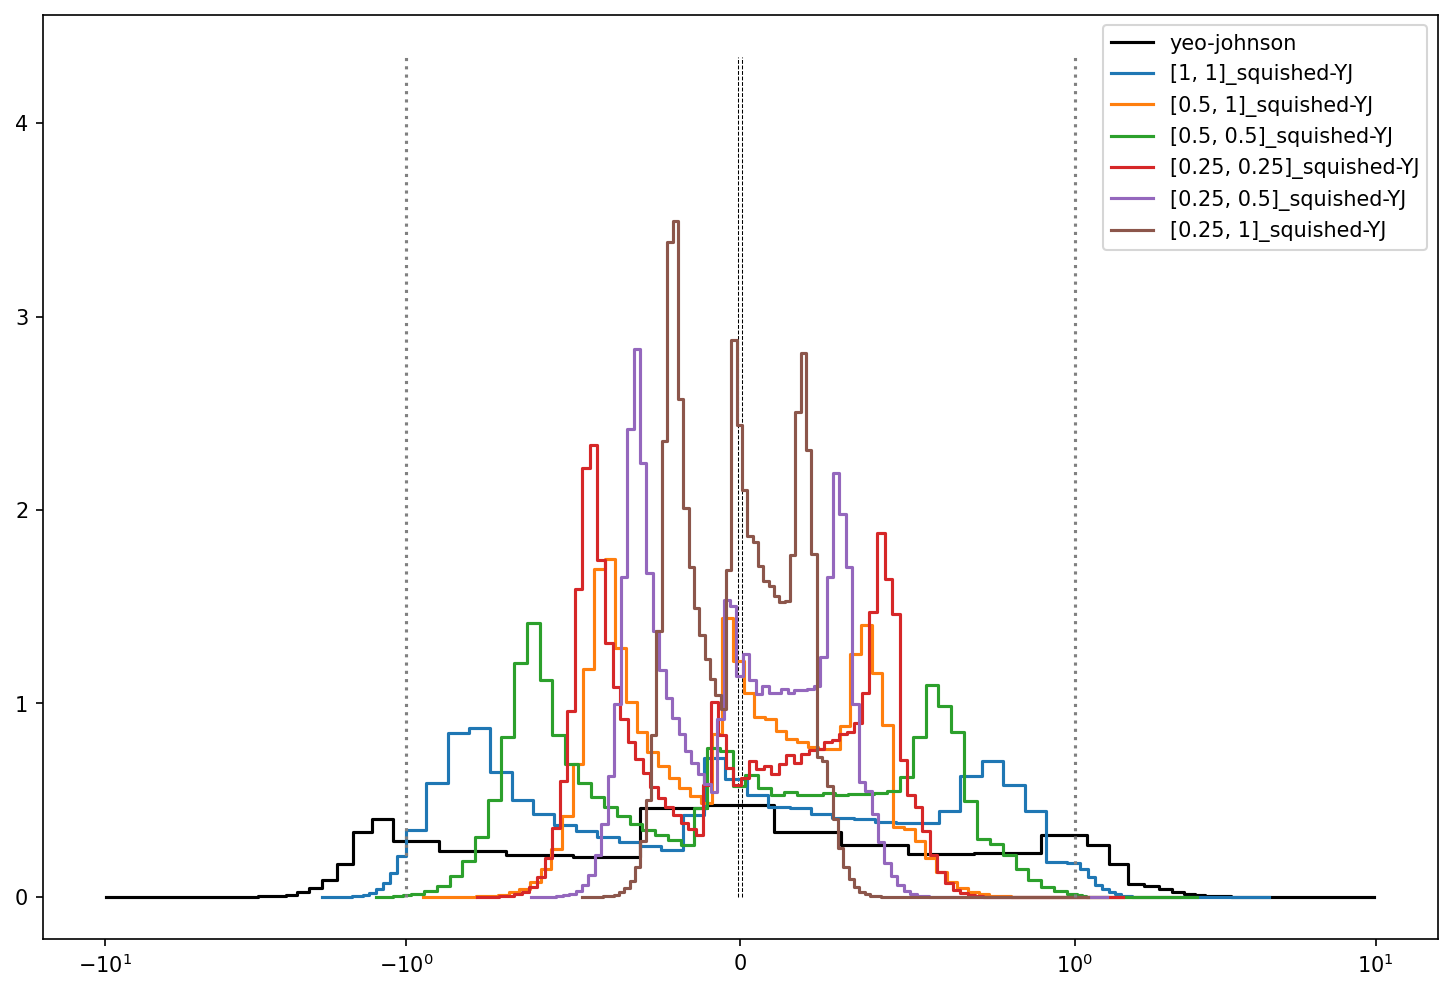

In [53]:
plt.figure(dpi=150, figsize=(12,8))

# plt.step((bin_edges_MinMax[:-1]+bin_edges_MinMax[1:])/2, hist_MinMax, label='min-max', color='grey')
# plt.vlines(
#     [x_MinMax.mean(), torch.median(x_MinMax)], 
#     # [x_normalized.mean(), x_normalized.mean()-x_normalized.std(), x_normalized.mean()+x_normalized.std(), torch.median(x_normalized)], 
#     ymin=0, ymax=hist_normalized.max(), color='grey', linestyle='--', linewidth=0.5)


# plt.step((bin_edges_normalized[:-1]+bin_edges_normalized[1:])/2, hist_normalized, label='mean-std', color='k')
# plt.vlines(
#     [x_normalized.mean(), torch.median(x_normalized)], 
#     # [x_normalized.mean(), x_normalized.mean()-x_normalized.std(), x_normalized.mean()+x_normalized.std(), torch.median(x_normalized)], 
#     ymin=0, ymax=hist_normalized.max(), color='k', linestyle='--', linewidth=0.5)


plt.step((bin_edges_reconstructed[1:]+bin_edges_reconstructed[:-1])/2, hist_reconstructed, label='yeo-johnson', color='k', linestyle='-')
plt.vlines(
    # [reconstructed_data.mean(), reconstructed_data.mean()-reconstructed_data.std(), reconstructed_data.mean()+reconstructed_data.std(), np.median(reconstructed_data)], 
    [reconstructed_data.mean(), np.median(reconstructed_data)], 
    ymin=0, ymax=hist_normalized.max(), color='k', linestyle='--', linewidth=0.5)


for i, Ak in enumerate([[1,1],[0.5,1],[0.5,0.5],[0.25,0.25],[0.25,0.5],[0.25,1]]):
    # Ak = [1,1]
    squished_data = squish(reconstructed_data, Ak)
    hist_squished, bin_edges_squished = np.histogram(squished_data.flatten(), bins=100, density=True)
    plt.step((bin_edges_squished[1:]+bin_edges_squished[:-1])/2, hist_squished, label=f'{Ak}_squished-YJ', color=f'C{i}', linestyle='-')#, linewidth=0.5)
    # plt.vlines(
    #     # [reconstructed_data.mean(), reconstructed_data.mean()-reconstructed_data.std(), reconstructed_data.mean()+reconstructed_data.std(), np.median(reconstructed_data)], 
    #     [squished_data.mean(), np.median(squished_data)], 
    #     ymin=0, ymax=1, color='b', linestyle=':')


# plt.xlim(-10,100)
plt.vlines([-1,1], ymin=0, ymax=hist_normalized.max(), color='grey', linestyle=':')
# plt.yscale('log')
plt.xscale('symlog', linthresh=1)
plt.legend()
plt.show()

In [42]:
# print(x.min(), x.max(), x.mean(), x.std())
# tensor(-6.9662) tensor(2.4401) tensor(-0.0074) tensor(0.9875)

In [4]:
# x_trainset, c_trainset, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir[4, 6]-zeta[10, 250]-0809-123640.h5')

# test and visualize dataset

In [5]:
# dataset = Dataset4h5(
#     os.path.join(os.environ['SCRATCH'], 'LEN128-DIM64-CUB16-Tvir[4, 6]-zeta[10, 250]-0809-123640.h5'), 
#     num_image=600, 
#     num_redshift=1024, 
#     HII_DIM=64, 
#     rescale=False, 
#     dim=3, 
#     # startat=0,
# )

In [6]:
# dataloader = DataLoader(dataset, batch_size=3000)
# x, c = next(iter(dataloader))
# print(x.shape, c.shape)
# # num = 800
# # plt.figure(dpi=100)
# # plt.scatter(c[0*num:1*num,0], c[0*num:1*num,1], s=50, edgecolor='black')
# # plt.scatter(c[1*num:2*num,0], c[1*num:2*num,1], s=50, edgecolor='black')
# # # plt.scatter(c[2*num:3*num,0], c[2*num:3*num,1], s=50, edgecolor='black')
# # # plt.scatter(c[3*num:4*num,0], c[3*num:4*num,1], s=50, edgecolor='black')
# # x = x[:,:,1]
# print(los.shape)
# print(x.min())
# print(x.max())
# print("normalized max =", (x.max()-ranges_dict['images'][0][0])/(ranges_dict['images'][0][1]-ranges_dict['images'][0][0])*2-1)
# print("normalized min =", (x.min()-ranges_dict['images'][0][0])/(ranges_dict['images'][0][1]-ranges_dict['images'][0][0])*2-1)
# x_flatten = x.flatten()

In [7]:
# for i in range(x.shape[2]):
#     print(i, "normalized max =", (x[:,:,i].max()-ranges_dict['images'][0][0])/(ranges_dict['images'][0][1]-ranges_dict['images'][0][0])*2-1, end="; ")
#     print("normalized min =", (x[:,:,i].min()-ranges_dict['images'][0][0])/(ranges_dict['images'][0][1]-ranges_dict['images'][0][0])*2-1)

In [8]:
# plt.plot((hist[1][1:]+hist[1][:-1])/2, hist[0], c='k')
# plt.vlines(x=[-387,0, 86], ymin=0, ymax=hist[0].max(), label="[-387, 0, 86]", color='red')
# plt.vlines(x=[ranges_dict['images'][0]], ymin=0, ymax=hist[0].max(), label=f"{ranges_dict['images'][0]}", color='blue')
# plt.vlines(x=np.percentile(x_flatten, [100-95, 95]), ymin=0, ymax=hist[0].max(), label="2 sigma", color='green')
# plt.yscale('log')
# plt.legend()
# plt.show()

# visualize training set

In [9]:
import matplotlib

def get_eor_cmap(vmin=-150, vmax=30):
    name = f"EoR-{vmin}-{vmax}"
    negative_segments = 4
    positive_segments = 2
    neg_frac = abs(vmin) / (vmax - vmin)
    neg_seg_size = neg_frac / negative_segments
    pos_frac = abs(vmax) / (vmax - vmin)
    pos_seg_size = pos_frac / positive_segments

    EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list(
        name,
        [
            (0, 'white'),
            (0.33, 'yellow'),
            (0.5, 'orange'),
            (0.68, 'red'),
            (0.83333333, 'black'),
            (0.9, 'blue'),
            (1, 'cyan')])
    
    try:
        matplotlib.colormaps.register(cmap=EoR_colour)
    except ValueError:
        matplotlib.colormaps.unregister(name)
        matplotlib.colormaps.register(cmap=EoR_colour)

    return name

vmin = -150#Tb_all.min()
vmax = 30#Tb_all.max()
# print(vmin, vmax)
cmap = get_eor_cmap(vmin, vmax)

torch.Size([256, 1, 64, 64, 32])


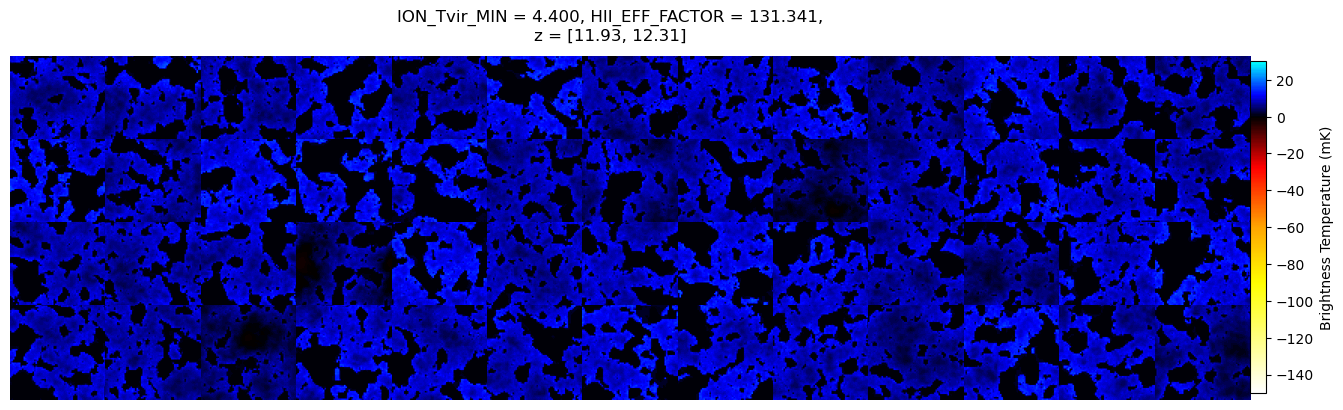

torch.Size([256, 1, 64, 64, 32])


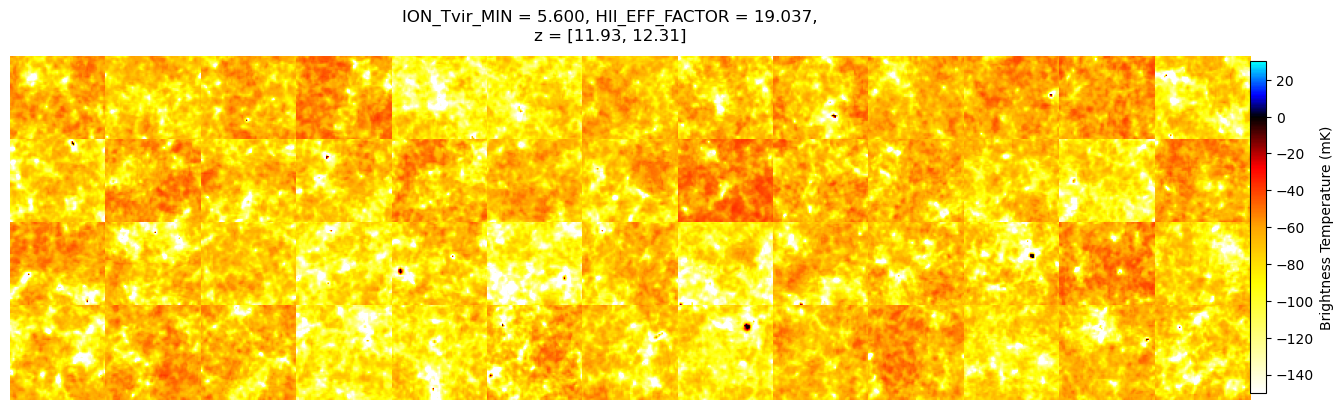

torch.Size([256, 1, 64, 64, 32])


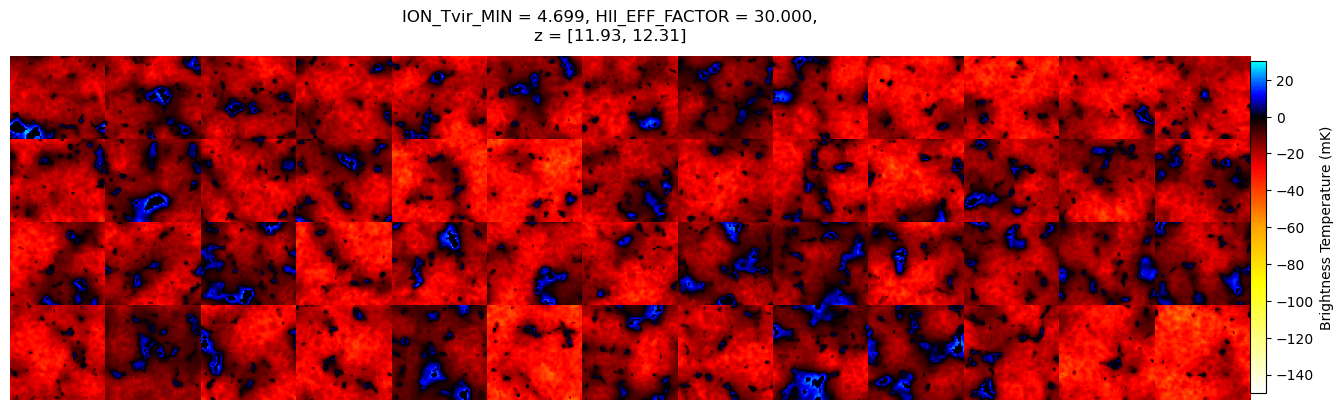

torch.Size([256, 1, 64, 64, 32])


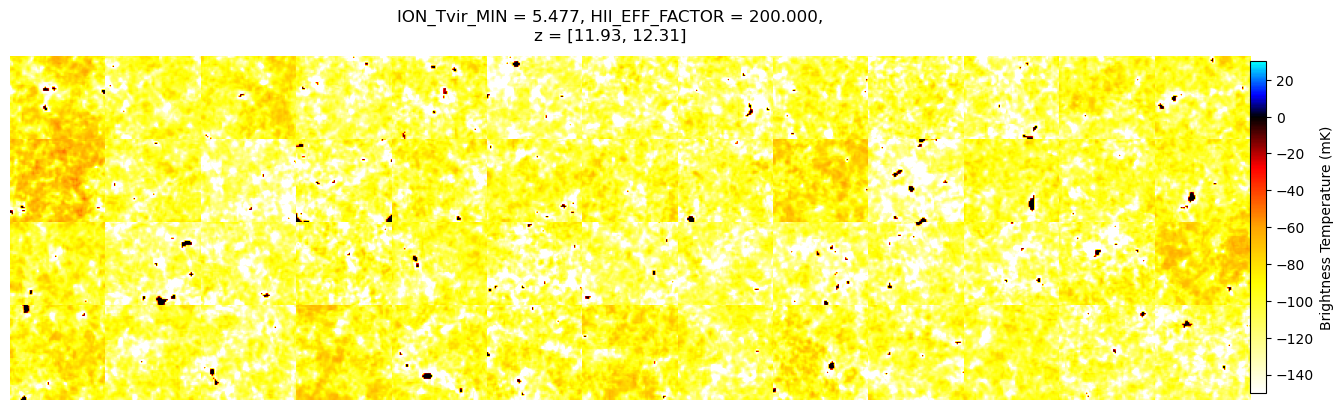

torch.Size([256, 1, 64, 64, 32])


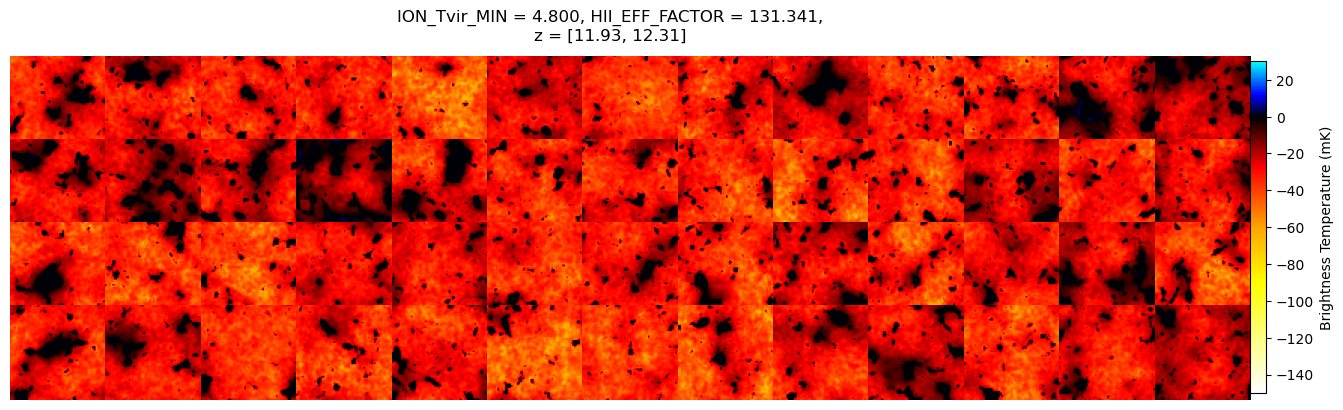

In [10]:
# for i in range(len(x)):
#     plt.imshow(x[i,0,:,0,:])
#     plt.show()
# row = 4
# col = 6
# samples = x[:,:,:,0,:]
def plot_grid(samples, c, row=4, col=13, idx=0, los=None, savename=None, figsize=(16, 4.5)):
    # plt.figure(dpi=200, figsize=(16, 5.5))
    fig, axes = plt.subplots(row, col, figsize=figsize, dpi=100)#, constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=-.15)
    axes = axes.flatten()
    print(samples.shape)
    for i in range(row*col):
        if i >= samples.shape[0]:
            axes[i].axis("off")
            continue
        if samples.ndim == 5:
            im = axes[i].imshow(samples[i,0,:,:,idx], cmap=cmap, vmin=vmin, vmax=vmax)
            # im = axes[i].imshow(samples[i,0,idx,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
        elif samples.ndim == 4:
            im = axes[i].imshow(samples[i,0,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i].axis("off")
        
    cbar_ax = fig.add_axes([0.90, 0.128, 0.01, 0.737]) 
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
    cbar.set_label('Brightness Temperature (mK)', fontsize=10) 
    
    plt.suptitle(f"ION_Tvir_MIN = {c[0][0]:.3f}, HII_EFF_FACTOR = {c[0][1]:.3f},\nz = [{los[0,0]:.2f}, {los[0,-1]:.2f}]")
    plt.colormaps()
    
    if savename is None:
        plt.show()
    else:
        plt.savefig(savename)
    plt.close()
    gc.collect()
    
plot_grid(x0, c=c0, los=los)
plot_grid(x1, c=c1, los=los)
plot_grid(x2, c=c2, los=los)
plot_grid(x3, c=c3, los=los)
plot_grid(x4, c=c4, los=los)

In [11]:
# for i in range(x0.shape[-1]):
#     plot_grid(x0, c=c0, los=los, idx = i, savename=f"x0_{i:02d}")
#     plot_grid(x2, c=c2, los=los, idx = i, savename=f"x2_{i:02d}")

In [12]:
import cv2
import glob
import os

def png2mp4(
    image_folder = ".",  # 你的图片所在的目录
    image_format = "x0_*.png",  # 你的图片格式
    output_video = "x0.mp4",  # 生成的视频文件
):
    # 读取所有匹配的 PNG 图片（按文件名排序）
    images = sorted(glob.glob(os.path.join(image_folder, image_format)))
    
    if not images:
        print("未找到匹配的 PNG 图片")
        exit()
    
    # 读取第一张图片以获取宽高
    frame = cv2.imread(images[0])
    h, w, _ = frame.shape
    
    # 创建 VideoWriter（H.264 编码）
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # 也可以用 'XVID' 或 'avc1'
    fps = 10  # 设置帧率（10帧/秒）
    video = cv2.VideoWriter(output_video, fourcc, fps, (w, h))
    
    # 逐帧写入视频
    for img_path in images:
        frame = cv2.imread(img_path)
        video.write(frame)
    
    # 释放资源
    video.release()
    print(f"video is saved as {output_video}")

# png2mp4()

In [13]:
# plot_grid(x_trainset[::19], c=c_trainset, row=20, col=1, idx=-1, los=los, figsize=(16, 20))

In [14]:
# c_trainset.shape
# plt.scatter(c_trainset[:,0], c_trainset[:,1])

In [15]:
# from scipy.stats import qmc
# sampler = qmc.LatinHypercube(d=2)
# l_bounds = [4, 10]
# u_bounds = [6, 250]
# sample = sampler.random(n=25600)
# sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

# sample_uniform = np.random.uniform(l_bounds, u_bounds, size=(25600,2))

In [16]:
# print(sample_scaled.shape)
# print(sample_uniform.shape)
# _ = plt.hist2d(sample_scaled[:,0], sample_scaled[:,1], bins=(20,20))
# plt.show()
# _ = plt.hist2d(sample_uniform[:,0], sample_uniform[:,1], bins=(20,20))

In [17]:
def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    ru *= (L/ng)**field.ndim

    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    # ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2

    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    if field.ndim == 3:
        k_nd = np.meshgrid(kx, ky, kz, indexing="ij")
        # print("field.ndim == 3:")
    elif field.ndim == 2:
        k_nd = np.meshgrid(kx, ky, indexing="ij")
        # print("field.ndim == 2:")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

    # hist, edges = np.histogram(k, weights=ru, bins=Nk)
    # Pk = ng * hist / kbins**(field.ndim - 1)
    
    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    if field.ndim == 3:
        Pk *= (kbins**3) / (2*np.pi**2)
    elif field.ndim == 2:
        Pk *= (kbins**2) / (4*np.pi**2)

    return kbins, Pk

In [18]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
# plt.figure(figsize=(6, 4), dpi=100)
# k_vals_all = []
def x2Pk(x):
    print(f"x.shape = {x.shape}")
    Pk_vals_all = []
    for i in range(x.shape[0]):
        if x.ndim == 4:
            # density_field = x[i,0,:,x.shape[-1]//2:x.shape[-1]//2+64]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
            density_field = x[i,0,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
        elif x.ndim == 5:
            density_field = x[i,0,:,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
            # density_field = x[i,0,:,:,x.shape[-1]//2:x.shape[-1]//2+64]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
        # print(density_field.shape)
        if density_field.ndim == 3:
            Nx, Ny, Nz = density_field.shape
            box_size = 128#(128.0, 128.0, 1024.0) #512#
        elif density_field.ndim == 2:
            Nx, Ny = density_field.shape
            box_size = 128#(128.0, 1024.0) #512#

        # 计算物质功率谱
        k_vals, Pk_vals = calc_ps(density_field, box_size)
        # k_vals_all.append(k_vals)
        Pk_vals_all.append(Pk_vals)

    Pk_vals_all = np.array(Pk_vals_all)
    return k_vals, Pk_vals_all
    # Pk_vals_all_sim = Pk_vals_all
# plt.xscale('log')
# plt.yscale('log')

# plt.tight_layout()
# plt.legend()
# plt.show()

# # plt.subplot(2, 1, 2)
# plt.plot(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
# plt.plot(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
# plt.xlabel('k [h/Mpc]')
# plt.ylabel('Power')
# plt.title('Normalized Power Spectrum')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(xmin=1e-2)
# plt.legend()
# plt.grid(True)

In [19]:
# x_norm = torch.randn(400,1,64,64,1024)
# plt.imshow(x_norm[0,0,0,:,:64])
# plt.show()
# del x_norm

In [20]:
# k_norm, Pk_norm = x2Pk((x_norm))
# Pk_norm_perc = np.percentile(Pk_norm, [32, 68], axis=0)
# # for i in range(Pk_norm.shape[0]):
# #     plt.plot(k_norm, Pk_norm[i])
# plt.fill_between(k_norm, Pk_norm_perc[0], Pk_norm_perc[1], alpha=0.1, facecolor=f"C0", edgecolor='black')
# plt.plot(k_norm, Pk_norm.mean(axis=0))
# plt.grid(which="both")
# plt.xscale("log")
# plt.yscale("log")
# plt.show()

In [21]:
# k_vals, Pk_vals_all_0_sim = x2Pk(x0[...,0])
# k_vals, Pk_vals_all_1_sim = x2Pk(x1[...,0])
# k_vals, Pk_vals_all_2_sim = x2Pk(x2[...,0])
# k_vals, Pk_vals_all_3_sim = x2Pk(x3[...,0])
# k_vals, Pk_vals_all_4_sim = x2Pk(x4[...,0])

In [22]:
def rescale(x, ranges=ranges_dict['images']):
    x = (x + 1) / 2 * (ranges[0][1]-ranges[0][0]) + ranges[0][0]
    return x
    
def x2Tb(x):
    print('x.shape =', x.shape, 'x.ndim =', x.ndim)
    if x.ndim == 4:
        Tb = x[:,0].mean(axis=1)
    elif x.ndim == 5:
        Tb = x[:,0].mean(axis=(1,2))
    return Tb

In [23]:
x0.ndim

5

# visualize testing set

fname pattern: Tvir4.400-zeta131.341 device_count4-node2-35661163-epoch360 ; len(fnames) = 8
fname pattern: Tvir5.600-zeta19.037 device_count4-node2-35661163-epoch360 ; len(fnames) = 8
fname pattern: Tvir4.699-zeta30.000 device_count4-node2-35661163-epoch360 ; len(fnames) = 8
fname pattern: Tvir5.477-zeta200.000 device_count4-node2-35661163-epoch360 ; len(fnames) = 8
fname pattern: Tvir4.800-zeta131.341 device_count4-node2-35661163-epoch360 ; len(fnames) = 8
torch.Size([256, 1, 64, 64, 32])


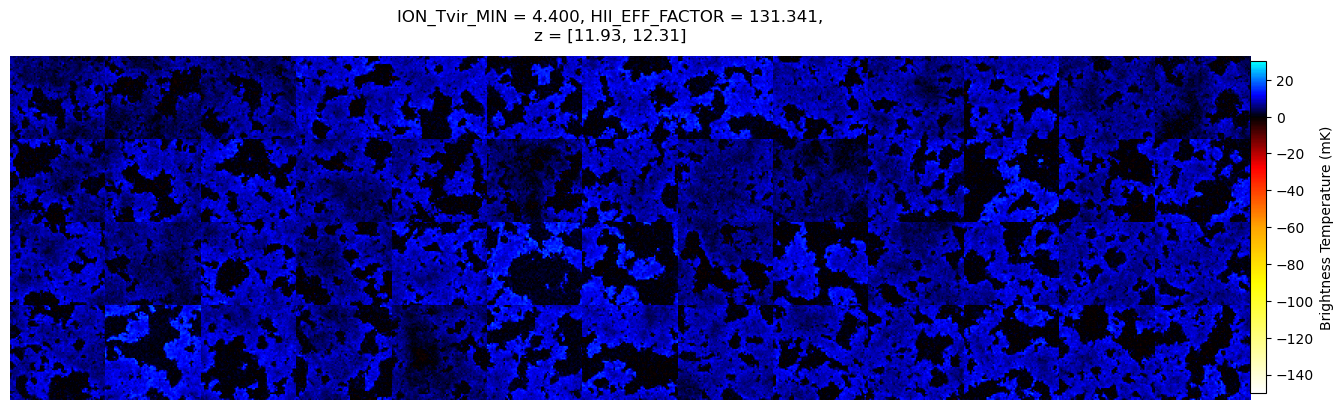

torch.Size([256, 1, 64, 64, 32])


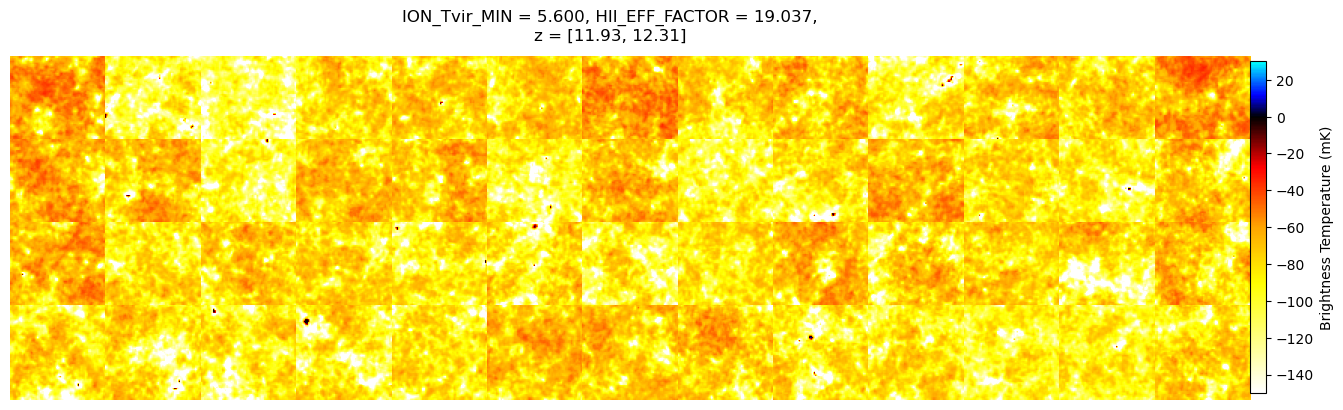

torch.Size([256, 1, 64, 64, 32])


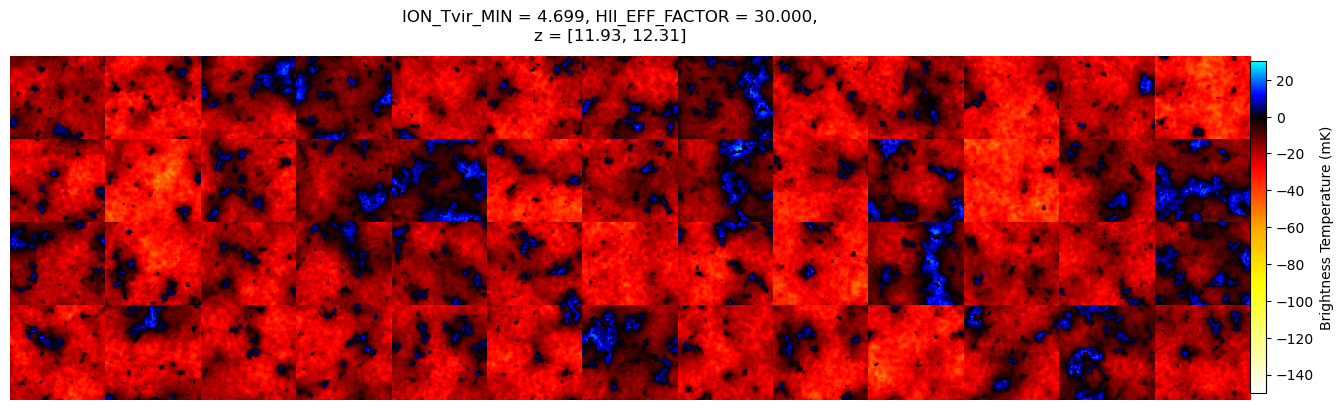

torch.Size([256, 1, 64, 64, 32])


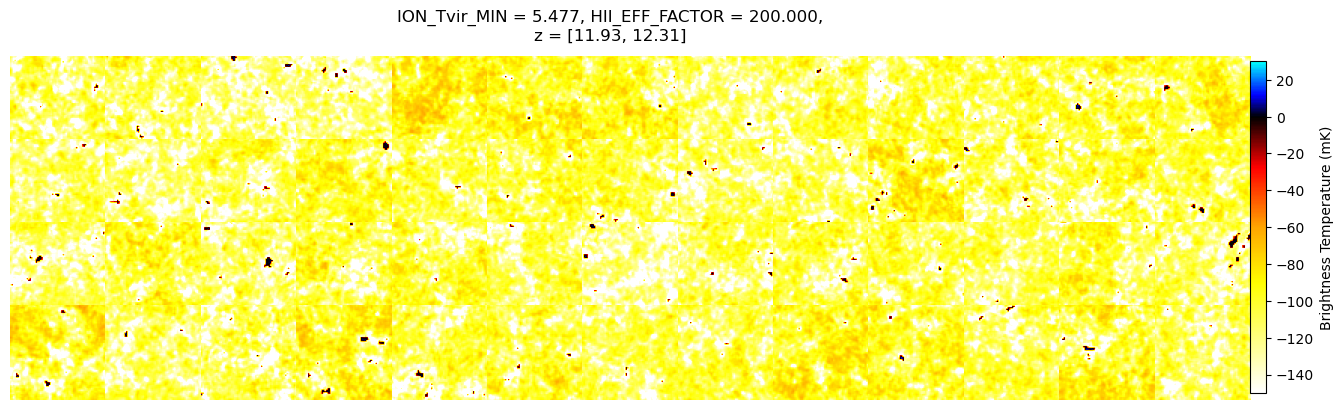

torch.Size([256, 1, 64, 64, 32])


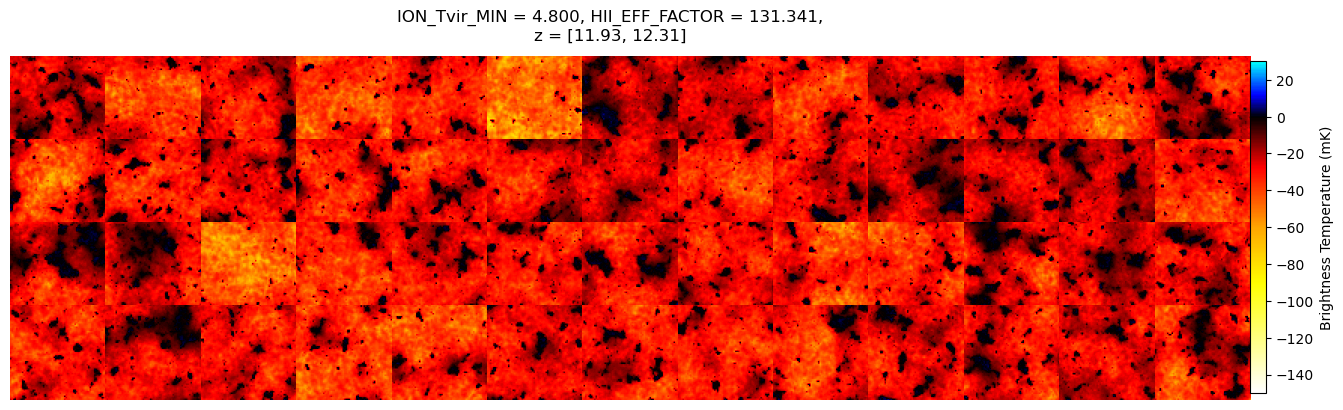

In [25]:
# x_ml = np.load("outputs/0527-1951.npy")
# x_ml = np.load("outputs/test_2_506.npy")
# x_ml = torch.from_numpy(x_ml)
# x_ml = unscale(x_ml)

# num = 3200
# x0_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.400000095367432-zeta131.34100341796875-N{num}.npy")))
# x1_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir5.599999904632568-zeta19.03700065612793-N{num}.npy")))
# x2_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.698999881744385-zeta30.0-N{num}.npy")))
# x3_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir5.4770002365112305-zeta200.0-N{num}.npy")))
# x4_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.800000190734863-zeta131.34100341796875-N{num}.npy")))
def load_x_ml(fname_pattern0, fname_pattern1, ema = 0):
    # num = 7200
    x_ml = []
    fnames = [fname for fname in os.listdir("outputs") if fname_pattern0 in fname and fname_pattern1 in fname]
    print("fname pattern:", fname_pattern0, fname_pattern1, "; len(fnames) =", len(fnames))
    # print("fname:",fnames)
    # print()
    for fname in fnames:
        if ema and 'ema1' not in fname:
            continue
        if not ema and 'ema1' in fname:
            continue
            
        data = np.load(os.path.join("outputs", fname))
        # print(fname)
        x_ml.append(data)
    x_ml = np.concatenate(x_ml, axis=0)
    x_ml = rescale(x_ml)
    x_ml = torch.from_numpy(x_ml)
    return x_ml

# num_image = 800 #1600 #800 #1600 # 1280 # 6400 # 12800 #
device_count = 4
node = 2
jobID = 35661163 #35680804 #35661141 #35327664 #35327630 #35258314 #35258310 #35258516 #35114004 #35111017 #35111024 #35079920 #35079904 #35079859 #35079880 #35079813 #35079767 #35015390 #34897409 #34897417 #34897428 #34897444 #34454672 #34454715 #34454627 #34454616 #34768123 #34193139 #34193147 #34127214 #34127204 #34193087 #34193091 #34193106 #34193110 #34193125 #34193131 #33965722 #34127173 #34107126 #33965702 #33965691 #33964016 #33958327 #33892215 #33892194 #33888507 #33867346 #33709643 #33707982 #33678194 #33660962
epoch = 360 #120

config = f"device_count{device_count}-node{node}-{jobID}-epoch{epoch}"
x0_ml = load_x_ml(f"Tvir4.400-zeta131.341", config)
x1_ml = load_x_ml(f"Tvir5.600-zeta19.037", config)
x2_ml = load_x_ml(f"Tvir4.699-zeta30.000", config)
x3_ml = load_x_ml(f"Tvir5.477-zeta200.000", config)
x4_ml = load_x_ml(f"Tvir4.800-zeta131.341", config)

plot_grid(x0_ml, c=c0, los=los)
plot_grid(x1_ml, c=c1, los=los)
plot_grid(x2_ml, c=c2, los=los)
plot_grid(x3_ml, c=c3, los=los)
plot_grid(x4_ml, c=c4, los=los)

In [26]:
# for i in range(x0_ml.shape[-1]):
#     plot_grid(x0_ml, c=c0, los=los, idx = i, savename=f"x0_ml{i:02d}")
#     plot_grid(x2_ml, c=c2, los=los, idx = i, savename=f"x2_ml{i:02d}")

In [27]:
# png2mp4(
#     image_folder = ".",  # 你的图片所在的目录
#     image_format = "x0_ml*.png",  # 你的图片格式
#     output_video = "x0_ml.mp4",  # 生成的视频文件
# )

# png2mp4(
#     image_folder = ".",  # 你的图片所在的目录
#     image_format = "x2_ml*.png",  # 你的图片格式
#     output_video = "x2_ml.mp4",  # 生成的视频文件
# )

In [28]:
# print(x2_ml.shape)
# for i in range(x2_ml.shape[2]):
#     plt.figure(dpi=200,figsize=(12,3))
#     plt.imshow(x2_ml[0,0,i], cmap=cmap, vmin=vmin, vmax=vmax)
#     plt.show()

In [29]:
# print(x2_ml.shape)
# for j in range(x2_ml.shape[-1]):
#     plt.figure(figsize=(5.7,3), dpi=200)
#     for i in range(x2_ml.shape[0]):
#         plt.subplot(2,4,i+1)
#         plt.imshow(x2_ml[i,0,...,j])
#         plt.axis("off")

#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.savefig(f"lightcone_test_{j:04d}.png")
#     plt.close()
#     # if j >= 10:
#     #     break

In [30]:
# print(x2.shape)
# y_hist, x_hist = np.histogram(x2.flatten(), bins=200, density = True)
# print(y_hist.shape, x_hist.shape)
# plt.plot((x_hist[1:]+x_hist[:-1])/2, y_hist)

# y_ml_hist, x_ml_hist = np.histogram(x2_ml.flatten(), bins=200, density = True)
# print(y_ml_hist.shape, x_ml_hist.shape)
# plt.plot((x_ml_hist[1:]+x_ml_hist[:-1])/2, y_ml_hist)

# # plt.yscale("log")

# evaluate the generated samples

In [31]:
def plot_global_signal(x_pairs, params, sigma_level=68.27, alpha=0.2, interval = 2, lw = 0.6, y_eps = 0.2):
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=200, gridspec_kw={'height_ratios': [1.5,.5,.5,.5]})
    
    for i, (x0, x1) in enumerate(x_pairs):
        # print(Tb0.shape)
        Tb0 = x2Tb(x0)
        Tb1 = x2Tb(x1)
        
        y0 = np.median(Tb0, axis=0)
        y1 = np.median(Tb1, axis=0)

        Tb0_perc = np.percentile(Tb0, [100-sigma_level, sigma_level], axis=0)
        ax[0].fill_between(los[1,:Tb0_perc.shape[-1]], Tb0_perc[0], Tb0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # ax[0].plot(los[1], Tb0[:4].T, lw=0.5)
        Tb1_perc = np.percentile(Tb1, [100-sigma_level, sigma_level], axis=0)
        yerr_lower = y1 - Tb1_perc[0]
        yerr_upper = Tb1_perc[1] - y1
        ax[0].errorbar(los[1,:Tb0_perc.shape[-1]][::interval], y1[::interval], yerr=[yerr_lower[::interval], yerr_upper[::interval]], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=lw)#, label='diffusion')

        ax[0].plot(los[1,:Tb0_perc.shape[-1]], y0, linestyle=':', c=f"C{i}", lw=3*lw)
        ax[1].plot(los[1,:Tb0_perc.shape[-1]][abs(y0)>y_eps], ((y1-y0)/abs(y0))[abs(y0)>y_eps], label=f'{np.array(params[i])}', c=f"C{i}", lw=lw)

        sigma0 = 0.5*(Tb0_perc[1]-Tb0_perc[0])
        sigma1 = 0.5*(Tb1_perc[1]-Tb1_perc[0])
        ax[2].plot(los[1,:Tb0_perc.shape[-1]][sigma0>1.5*y_eps], ((y1-y0)/sigma0)[sigma0>1.5*y_eps], label=f'{np.array(params[i])}', c=f"C{i}", lw=lw)
        
        ax[3].plot(los[1,:Tb0_perc.shape[-1]][sigma0>1.5*y_eps], (sigma1/sigma0-1)[sigma0>1.5*y_eps], c=f"C{i}", lw=lw)

    ax[0].set_ylabel(r'$\langle T_b \rangle$ [mK]')
    ax[0].grid()
    
    ax1_handles, ax1_labels = ax[1].get_legend_handles_labels()
    
    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=8)
    
    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    legend_labels = ['21cmfast', 'diffusion']
    # 添加自定义图例
    ax[0].legend(
        legend_elements + ax1_handles, 
        legend_labels + ax1_labels, 
        handler_map={tuple: HandlerTuple(ndivide=None)}, 
    )

    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    ax[1].set_yscale("symlog", linthresh=0.1)

    ax[1].grid()
    
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])

    ax[2].set_ylabel(r"$\epsilon_{std}$")
    
    ax[3].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1000:.1f}'))
    ax[3].set_xlabel('distance [Gpc]')
    ax[2].grid()
    ax[3].grid()
    
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")
    
    ax_twin = ax[3].secondary_xaxis('bottom')               # 创建共享 y 轴的第二个 x 轴
    ax_twin.set_xlim(ax[3].get_xlim())       # 设置副 x 轴的范围与主 x 轴相同
    ax_twin.set_xlabel('redshift')           # 设置副 x 轴标签
    ax_twin.xaxis.set_major_locator(ticker.MaxNLocator(10))  # 这里5表示最多显示5个刻度
    ax_twin.set_xticks(ax_twin.get_xticks())                  # 设置刻度为 z 的值
    z_ticks = interp(ax_twin.get_xticks(), los[1], los[0])
    ax_twin.set_xticklabels([f"{ztick:.1f}" for ztick in z_ticks])
    ax_twin.spines['bottom'].set_position(('outward', 40))  # 将副 x 轴向外移动 40 像素
    
    for axis in ax:
        axis.tick_params(axis='y', labelsize=10)  # 设置所有子图的 y 轴刻度标签字体大小为 8

    plt.subplots_adjust(hspace=0)


Relative error: $$\epsilon_\text{rel} = \frac{median_{ml} - median_{sim}}{median_{sim}}$$
Standard error: $$\epsilon_\text{std} = \frac{median_{ml} - median_{sim}}{\sigma_{sim}}$$
Relative standard deviation error: $$\epsilon_{\sigma} = \frac{\sigma_{ml} - \sigma_{sim}}{\sigma_{sim}}$$


In [32]:
print(x0.shape)
print(x0_ml.shape)
print(x0_ml.shape[-1])

torch.Size([256, 1, 64, 64, 32])
torch.Size([256, 1, 64, 64, 32])
32


x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5
x.shape = torch.Size([256, 1, 64, 64, 32]) x.ndim = 5


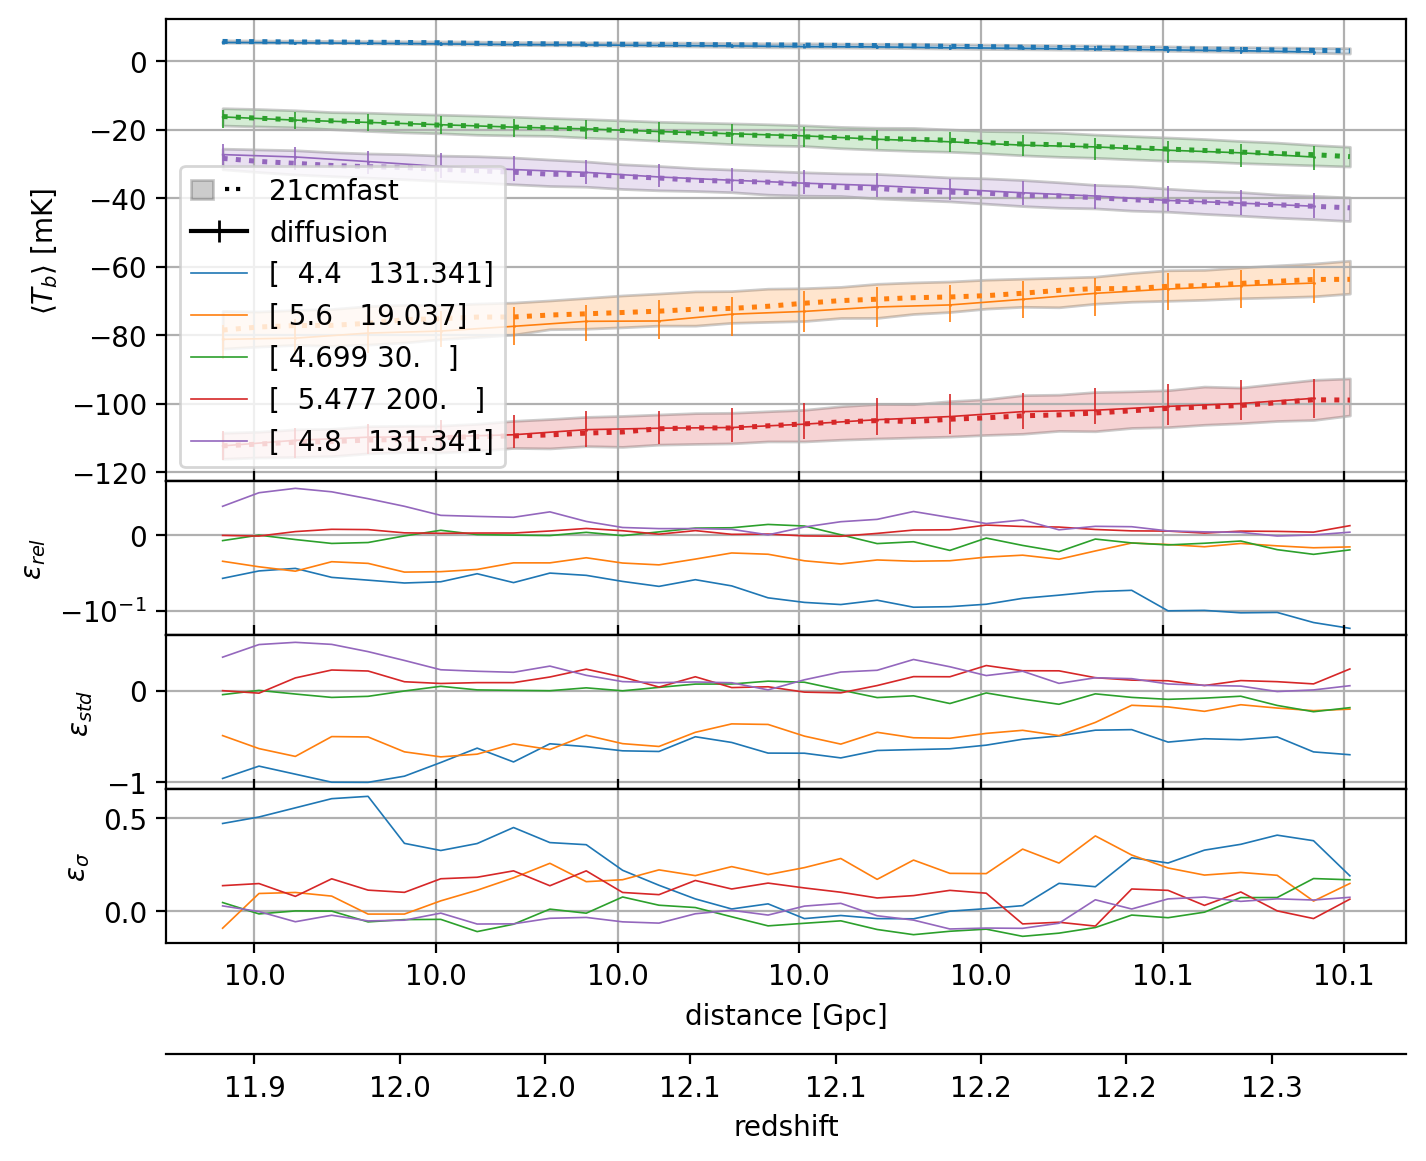

In [33]:
# plot_global_signal(
#     [
#         (x0[...,0],x0_ml[...,0]),
#         (x1[...,0],x1_ml[...,0]),
#         (x2[...,0],x2_ml[...,0]),
#         (x3[...,0],x3_ml[...,0]),
#         (x4[...,0],x4_ml[...,0]),
        
#         # (x0,x0_ml),
#         # (x1,x1_ml),
#         # (x2,x2_ml),
#         # (x3,x3_ml),
#         # (x4,x4_ml),
#         ],
#     params = [
#         c0[0], 
#         c1[0],
#         c2[0],
#         c3[0], 
#         c4[0],
#     ],
#     # sigma_level=100,
#     )


plot_global_signal(
    [
        # (x0[...,0], x0_ml[...,0]),
        # (x1[...,0], x1_ml[...,0]),
        # (x2[...,0], x2_ml[...,0]),
        # (x3[...,0], x3_ml[...,0]),
        # (x4[...,0], x4_ml[...,0]),
        
        # (x0[...,0],x0_ml),#[...,-1])
        # (x1[...,0],x1_ml),#[...,-1])
        # (x2[...,0],x2_ml),#[...,-1])
        # (x3[...,0],x3_ml),#[...,-1])
        # (x4[...,0],x4_ml),#[...,-1])
        
        (x0[...,:x0_ml.shape[-1]],x0_ml),#[...,-1])
        (x1[...,:x0_ml.shape[-1]],x1_ml),#[...,-1])
        (x2[...,:x0_ml.shape[-1]],x2_ml),#[...,-1])
        (x3[...,:x0_ml.shape[-1]],x3_ml),#[...,-1])
        (x4[...,:x0_ml.shape[-1]],x4_ml),#[...,-1])
        
        # (x0,x0_ml),
        # (x1,x1_ml),
        # (x2,x2_ml),
        # (x3,x3_ml),
        # (x4,x4_ml),
        ],
    params = [
        c0[0], 
        c1[0],
        c2[0],
        c3[0], 
        c4[0],
    ],
    # sigma_level=100,
    )

In [34]:
# sigma_level = 68

# for i in range(Pk_vals_all_0_ml.shape[0]):
#     plt.plot(k_vals, Pk_vals_all_0_ml[i], lw=0.1)

# plt.fill_between(k_vals, np.percentile(Pk_vals_all_0_ml, sigma_level, axis=0), np.percentile(Pk_vals_all_0_ml, 100-sigma_level, axis=0), alpha=1, facecolor=f"C0", edgecolor='black')#, hatch='/')
# print('i =', i)
# plt.yscale('log')
# # plt.xscale('log')

In [35]:
def plot_power_spectrum(Pk_pairs, params, sigma_level=68.27, alpha=0.2, redshift=None):
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=200)
    for i, (Pk0, Pk1) in enumerate(Pk_pairs):
        y0 = np.median(Pk0, axis=0)
        y1 = np.median(Pk1, axis=0)

        # k_vals_all = np.array(k_vals_all)
        # print(k_vals_all.shape)
        # print(Pk_vals_all.shape)
            # plt.subplot(2, 1, 2)
            # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
            # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
            # plt.xlabel('k [h/Mpc]')
            # plt.ylabel('Power')
            # plt.title('Normalized Power Spectrum')
            # # plt.legend()
            # plt.grid(True)
        # sigma_level = 0
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk0, axis=0), 'b--', lw=1)
        Pk0_perc = np.percentile(Pk0, [100-sigma_level, sigma_level], axis=0)
        ax[0].fill_between(k_vals, Pk0_perc[0], Pk0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk1, axis=0), 'r--', lw=1)
        # ax[0].fill_between(k_vals, np.percentile(Pk1, 100-sigma_level, axis=0), np.percentile(Pk1, sigma_level, axis=0), alpha=alpha/3, facecolor=f"C{i}", edgecolor='black', hatch='/')

        ax[0].plot(k_vals, y0, linestyle=':', c=f"C{i}")#, label='sim')
        # line_sim = (line_sim, Patch(facecolor='black', edgecolor='none', alpha=alpha))
        # 添加自定义图例
        # ax[0].legend(legend_elements, ['Solid line with fill_between'], handler_map={tuple: HandlerTuple(ndivide=None)})

        Pk1_perc = np.percentile(Pk1, [100-sigma_level, sigma_level], axis=0)
        yerr_lower = y1 - Pk1_perc[0]
        yerr_upper = Pk1_perc[1] - y1
        ax[0].errorbar(k_vals, y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)#, label='diffusion')
        
        # plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
        # plt.plot(k_vals_all_sim.mean(axis=0), Pk0.mean(axis=0), 'k-', lw=1, label="simulations' mean")
        # plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
        ax[1].plot(k_vals, (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")

        sigma = 0.5*(Pk0_perc[1]-Pk0_perc[0])
        ax[2].plot(k_vals, (y1-y0)/sigma, label=f'{np.array(params[i])}', c=f"C{i}")

        ax[3].plot(k_vals, (Pk1_perc[1]-Pk1_perc[0])/2/sigma-1, c=f"C{i}")

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\Delta^2(k)$ [mK$^2$]')
        # plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
        # plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
    ax[0].grid()
    
    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=10)

    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    # 添加自定义图例
    ax[0].legend(legend_elements, ['21cmfast', 'diffusion'], handler_map={tuple: HandlerTuple(ndivide=None)})

    
    # solid = Line2D([0],[0], color='k', linestyle='-', label='sim')
    # solid = line_sim
    # dashed = Line2D([0],[0], color='k', linestyle='--', label='ml', marker='+')
    # legend0 = ax[0].legend(handles=[solid,dashed])
    # dashed = Line2D([0],[0], color='k', linestyle='--', label='ml', marker='+')
    # legend0 = ax[0].legend(handles=[line_sim,dashed])

    ax[0].set_title(r"power spectrum of $T_b$ at z = "+f"{los[0].mean():.2f}")
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    # ax[1].set_xlabel('k [Mpc$^{-1}$]')
    ax[1].grid()
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].legend()

    ax[2].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[2].set_ylabel(r"$\epsilon_{std}$")
    # ax[3].set_xlabel('k [Mpc$^{-1}$]')
    ax[2].grid()
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

    ax[3].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")
    ax[3].set_xlabel('k [Mpc$^{-1}$]')
    ax[3].grid()
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])


    # xs.set_xticks([])
    # xs = ax[1].secondary_xaxis('top')
    # ax[2].legend()
        # plt.plot(k_vals, , 'r-', label='diffusion')

        # plt.tight_layout()
        # plt.setp(ax[0].get_xticklabels(), visible=True)
        # ax[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.subplots_adjust(hspace=0)
    # plt.grid()
        # plt.show()
    # plt.suptitle("test title")
    # plt.tight_layout()


In [37]:
# k_vals, Pk_vals_all_0_sim = x2Pk(x0)
# k_vals, Pk_vals_all_1_sim = x2Pk(x1)
# k_vals, Pk_vals_all_2_sim = x2Pk(x2)
# k_vals, Pk_vals_all_3_sim = x2Pk(x3)
# k_vals, Pk_vals_all_4_sim = x2Pk(x4)

k_vals, Pk_vals_all_0_sim = x2Pk(x0[...,0])
k_vals, Pk_vals_all_1_sim = x2Pk(x1[...,0])
k_vals, Pk_vals_all_2_sim = x2Pk(x2[...,0])
k_vals, Pk_vals_all_3_sim = x2Pk(x3[...,0])
k_vals, Pk_vals_all_4_sim = x2Pk(x4[...,0])

x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])


In [38]:
# k_vals, Pk_vals_all_0_ml = x2Pk(x0_ml)
# k_vals, Pk_vals_all_1_ml = x2Pk(x1_ml)
# k_vals, Pk_vals_all_2_ml = x2Pk(x2_ml)
# k_vals, Pk_vals_all_3_ml = x2Pk(x3_ml)
# k_vals, Pk_vals_all_4_ml = x2Pk(x4_ml)

k_vals, Pk_vals_all_0_ml = x2Pk(x0_ml[...,0])
k_vals, Pk_vals_all_1_ml = x2Pk(x1_ml[...,0])
k_vals, Pk_vals_all_2_ml = x2Pk(x2_ml[...,0])
k_vals, Pk_vals_all_3_ml = x2Pk(x3_ml[...,0])
k_vals, Pk_vals_all_4_ml = x2Pk(x4_ml[...,0])

x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])
x.shape = torch.Size([256, 1, 64, 64])


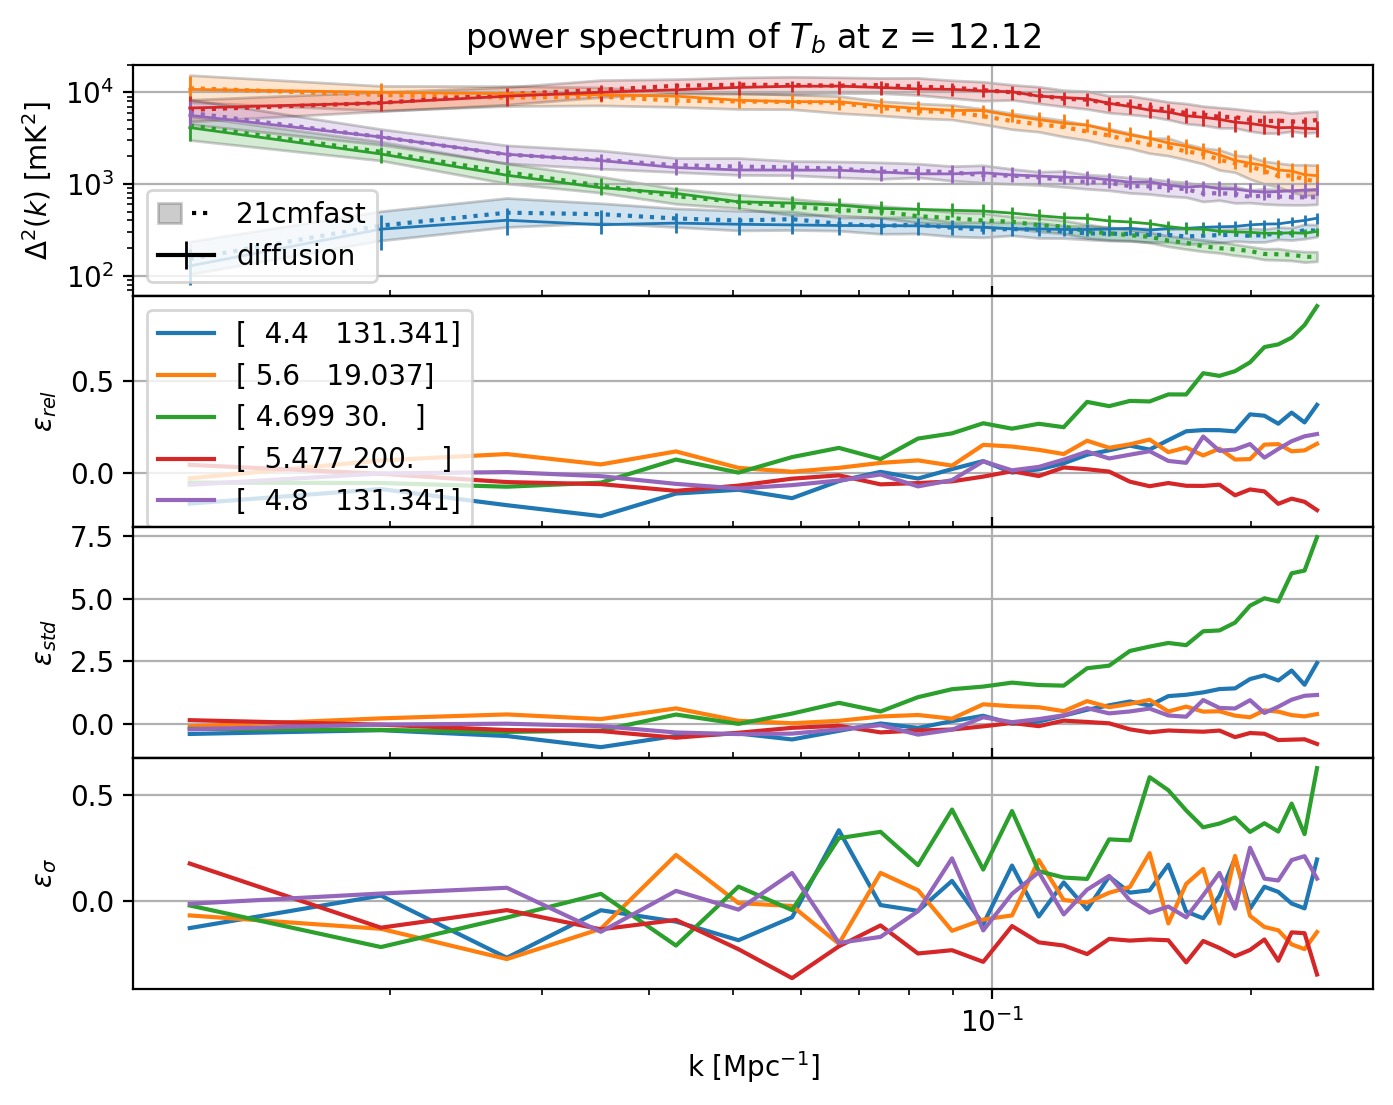

In [39]:
plot_power_spectrum(
    [
        # (Pk_vals_all_0_sim, Pk_vals_all_0_ml_d1_n1), 
        # (Pk_vals_all_0_sim, Pk_vals_all_0_ml_d1_n1), 
        # (Pk_vals_all_0_sim, Pk_vals_all_0_ml_d3_n1), 
        # (Pk_vals_all_0_sim, Pk_vals_all_0_ml_d3_n2), 
        # (Pk_vals_all_0_sim, Pk_vals_all_0_ml_d1_n6), 
        (Pk_vals_all_0_sim, Pk_vals_all_0_ml), 
        (Pk_vals_all_1_sim, Pk_vals_all_1_ml),
        (Pk_vals_all_2_sim, Pk_vals_all_2_ml), 
        (Pk_vals_all_3_sim, Pk_vals_all_3_ml),
        (Pk_vals_all_4_sim, Pk_vals_all_4_ml),
    ],
    params = [
        # [1,1],
        # [1,1],
        # [3,1],
        # [3,2],
        # [1,6],
        c0[0], 
        c1[0],
        c2[0], 
        c3[0], 
        c4[0],
    ],
    # sigma_level=95，
    )
# plt.grid()
# plot_power_spectrum(Pk_vals_all_diffusion, Pk_vals_all_diffusion)

In [40]:
# print(Pk_vals_all_0_sim.shape)
# print(Pk_vals_all_0_sim[0])

In [41]:
x0.device

device(type='cpu')

In [42]:
# print(abs((1,-2,3)))

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def sort_S2_by_l(S2, jthetas, L):
    # print("S2.shape =", S2.shape)
    S2_sorted = np.empty((L, S2.shape[0], S2.shape[1]//L))
    jthetas_sorted = np.empty((L, S2.shape[1]//L, 2, 2))
    # jthetas_sorted = [[]]*L
    num_updated = np.zeros(L, dtype=int)

    # print("jthetas =", jthetas)
    for i, jtheta in enumerate(jthetas):
        index = (jtheta[1][1]-jtheta[1][0]) % L
        # print("index =", index)
        # print("num_updated =", num_updated)
        S2_sorted[index, :, num_updated[index]] = S2[:,i]
        # print("sort_S2_by_l", jthetas_sorted[index*L+num_updated[index]], np.array(jtheta))
        jthetas_sorted[index, num_updated[index]][0] = jtheta[0]
        jthetas_sorted[index, num_updated[index]][1] = jtheta[1]
        # print("S2_sorted[:, index*L+num_updated[index]] =", S2_sorted[:, index*L+num_updated[index]])
        # jthetas_sorted[index] = jtheta
        # print("jtheta =", jtheta)
        # print("jthetas_sorted.shape =", jthetas_sorted.shape)
        # print("left =", jthetas_sorted[index*L+num_updated[index],:])
        # print("right =", np.array(jtheta))
        # jthetas_sorted[index*L+num_updated[index],:] = np.array(jtheta)
        # print("index, S2_sorted.shape =", index, np.shape(S2_sorted))
        num_updated[index] += 1
    # print("index*L+num_updated[index]", index*L+num_updated[index])
    # print("i =", i)
    # print("sort_S2_by_l, num_updated =", num_updated)

    S2_sorted = np.array(S2_sorted)
    # print("S2_sorted.shape", S2_sorted.shape)
    # print("S2_sorted", S2_sorted)
    jthetas_sorted = np.array(jthetas_sorted)
    # print('sort_S2_by_l S2_sorted.shape',S2_sorted.shape)
    # print('sort_S2_by_l jthetas_sorted.shape', jthetas_sorted.shape)
    return S2_sorted, jthetas_sorted


def calculate_sorted_S2(x, S, J, L, jthetas):
    S_all = np.mean(S(x.to(device))[:,0].cpu().numpy(), axis=(2,3))
    # print("calculate_sorted_S2, S2.shape =", S_all.shape)
    # print("calculate_sorted_S2, jthetas.shape =", jthetas.shape)
    # print("calculate_sorted_S2, jthetas[21:41] =", jthetas[21:41])
    # print("calculate_sorted_S2, jthetas[-1] =", jthetas[-1])

    ############################################################
    for j1 in range(J-1):
        for j2 in range(j1+1, J):
            # if j2>j1:
            # print("j1", j1, "j2", j2)
            index = [jtheta[0] == (j1,j2) for jtheta in jthetas]
            # print(index)
            # print(jthetas[index])
            # cache = S2[:,index]
            # print(index)
            if (j1,j2) == (0,1):
                S2 = S_all[:,index]
                jthetas_2 = np.array(jthetas[index])
                # index_reduced = index
            else:
                S2 = np.concatenate((S2, S_all[:,index]), axis = 1)
                jthetas_2 = np.concatenate([jthetas_2, np.array(jthetas[index])], axis = 0)
                # index_reduced = np.concatenate((index_reduced, index))
    ############################################################

    # index = 1+L*J
    # S2 = S_all[:,index:]
    # jthetas_2 = jthetas[index:]
    # print("calculate_reduced_S2 S2.shape", S2.shape)
    # print("calculate_sorted_S2 jthetas_2.shape", jthetas_2.shape)
    # print("calculate_sorted_S2 jthetas_2[:20]", jthetas_2[:20])
    # print(jthetas_reduced[:3])

    S2_sorted, jthetas_sorted = sort_S2_by_l(S2, jthetas_2, L)
    # print(index_reduced.shape)
    return S2_sorted, jthetas_sorted

def calculate_reduced_S2(x_pairs, params, J=5, L=4, M=64, N=64):
    S2_reduced_list = []
    jthetas_reduced_list = []
    for i, (x0, x1) in enumerate(x_pairs):
        print(f"#{i}: x0.shape = {x0.shape}, x1.shape = {x1.shape}")
        # get jthetas and S
        if i == 0:
            S = Scattering2D(J, (M, N), L=L, out_type='list').to(device)
            jthetas = []
            for dicts in S(x0.to(device)):
                jthetas.append([dicts['j'], dicts['theta']])
            # print(jthetas[0])
            # print(jthetas[1])
            # print(jthetas[2])
            # print(jthetas[3])
            # print(jthetas[-2])
            # print(jthetas[-1])
            jthetas = np.array(jthetas, dtype=object)
            S = Scattering2D(J, (M, N), L=L).to(device)
            # print("type(dicts[j])", type(dicts['j']), dicts['j'])
        # print("plot_scattering_transform_2 jthetas.shape", jthetas.shape)
        # print(jthetas[0], jthetas[1], jthetas[160])
        S2_reduced_0, jthetas_reduced_0 = calculate_sorted_S2(x0, S, J, L, jthetas)
        S2_reduced_1, jthetas_reduced_1 = calculate_sorted_S2(x1, S, J, L, jthetas)
        # print("S2_reduced.shape =", S2_reduced.shape)
        S2_reduced_list.append((S2_reduced_0, S2_reduced_1))
        jthetas_reduced_list.append((jthetas_reduced_0, jthetas_reduced_1))

    return S2_reduced_list, jthetas_reduced_list

cuda


In [44]:
def average_single_S2_over_l(S2, jthetas, L=4):
    # print("average_single_S2_over_l, shape =", S2.shape, jthetas.shape)
    S2_reshape = np.array(np.array_split(S2, S2.shape[2]//L, axis=2))
    # jthetas_reshape = jthetas.reshape(jthetas.shape[0],jthetas.shape[1]//L, L,jthetas.shape[2],jthetas.shape[3])
    jthetas_reshape = np.array(np.array_split(jthetas, jthetas.shape[1]//L, axis=1))
    # print("average_single_S2_over_l, shape =", S2_reshape.shape, jthetas_reshape.shape)
    # print("---"*30)
    # print(jthetas_reshape[0])
    # print("---"*30)
    S2_average = np.average(S2_reshape, axis=3)
    # jthetas_average = np.average(jthetas_reshape, axis=2)
    jthetas_average = jthetas_reshape[:,:,0,0,:]
    # print(S2_average.shape, jthetas_average.shape)
    # print(jthetas_average)
    # print("---"*30)
    S2_transpose = S2_average.transpose(2,1,0)
    # print(S2_transpose.shape)
    # print("---"*30)
    S2_combine = S2_transpose.reshape(S2_transpose.shape[0], -1)
    # print(S2_combine.shape)
    # print("---"*30)
    j1j2 = jthetas_average.transpose(1,0,2).reshape(-1, 2)
    # j1j2 = np.tile(jthetas_average, (S2_combine.shape[1]//jthetas_average.shape[0],1))
        # S2_average.append(())
    return S2_combine, j1j2.astype(int)

def average_S2_over_l(x_pairs, params, J, L, M, N):

    S2_list, jthetas_list = calculate_reduced_S2(x_pairs, params, J, L, M, N)

    S2_average = []
    j1j2_average = []
    for i in range(len(S2_list)):
        S2_sim = S2_list[i][0]
        jthetas_sim = jthetas_list[i][0]
        S2_combine_sim, j1j2_sim = average_single_S2_over_l(S2_sim, jthetas_sim, L)

        S2_ml = S2_list[i][1]
        jthetas_ml = jthetas_list[i][1]
        S2_combine_ml, j1j2_ml = average_single_S2_over_l(S2_ml, jthetas_ml, L)

        S2_average.append((S2_combine_sim, S2_combine_ml))
        j1j2_average.append((j1j2_sim, j1j2_ml))
    return np.array(S2_average), np.array(j1j2_average)

    # print(S2)
# S2, j1j2 = average_S2_over_l(S2_reduced, jthetas_reduced)
# print(np.shape(S2), np.shape(j1j2))

In [45]:
print(x0.shape)
print(x0_ml.shape)

torch.Size([256, 1, 64, 64, 32])
torch.Size([256, 1, 64, 64, 32])


In [46]:
def plot_scattering_transform_2(x_pairs, params, sigma_level=68.27, alpha=0.2, J=5, L=4, M=64, N=64):
    # S2_reduced, jthetas_reduced = calculate_reduced_S2(x_pairs, params, J, L, M, N)
    S2, j1j2 = average_S2_over_l(x_pairs, params, J, L, M, N)
    print("S2.shape, j1j2.shape =", S2.shape, j1j2.shape)
    # plt.figure(dpi=200, figsize=(12,4))
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(12,6), dpi=200)
    ax[0].set_title(f"reduced scattering coefficients at z = {los[0].mean():.2f}")
    # S2 = S2[..., :20]
    print("S2.min() =", S2.min())
    S2 = np.log10(S2)
    # j1j2 = j1j2[..., :S2.shape[3], :]
    j1j2 = j1j2[0,0]
    for i in range(len(S2)):
        S2_sim = S2[i][0]
        S2_ml = S2[i][1]

        y0 = np.median(S2_sim, axis=0)
        y1 = np.median(S2_ml, axis=0)
        # print(y0.shape)
        ax[0].plot(np.arange(y0.shape[0]), y0, lw=1, c=f"C{i}", linestyle=':')
        # plt.plot(np.median(S2_ml, axis=0), lw=1)

        S2_sim_perc = np.percentile(S2_sim, [100-sigma_level, sigma_level], axis=0)
        # S2_ml_perc = np.percentile(S2_ml, [100-sigma_level, sigma_level], axis=0)
        ax[0].fill_between(np.arange(S2_sim.shape[1]), S2_sim_perc[0], S2_sim_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # plt.fill_between(np.arange(S2_ml.shape[1]), S2_ml_perc[0], S2_ml_perc[1], alpha=alpha)

        S2_ml_perc = np.percentile(S2_ml, [100-sigma_level, sigma_level], axis=0)
        yerr_lower = y1 - S2_ml_perc[0]
        yerr_upper = S2_ml_perc[1] - y1
        ax[0].errorbar(np.arange(y1.shape[0]), y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)#, label='diffusion')

        ax[1].plot(np.arange(y0.shape[0]), ((y1-y0)/y0), label=f'{np.array(params[i])}', c=f"C{i}")

        sigma = (S2_sim_perc[1]-S2_sim_perc[0])/2
        ax[2].plot(np.arange(y0.shape[0]), (y1-y0)/sigma, label=f'{np.array(params[i])}', c=f"C{i}")

        # ax[3].plot(np.arange(y0.shape[0]), (S2_sim_perc[1]-S2_sim_perc[0])/sigma-1, c=f"C{i}")
        ax[3].plot(np.arange(y0.shape[0]), (S2_ml_perc[1]-S2_ml_perc[0])/2/sigma-1, c=f"C{i}")

    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=10)

    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    # 添加自定义图例
    ax[0].legend(legend_elements, ['21cmfast', 'diffusion'], handler_map={tuple: HandlerTuple(ndivide=None)})

    ax[0].set_ylabel(r'$\log{S_2}$')
    ax[0].grid()
    j1j2_period = j1j2.shape[0]//L

    # plt.text()
    ax[0].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[0].get_ylim()[0], ax[0].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[1].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[1].get_ylim()[0], ax[1].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[2].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[2].get_ylim()[0], ax[2].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[3].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[3].get_ylim()[0], ax[3].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')

    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylabel(r'$\epsilon_{rel}$')

    # ax[2].set_xticks(np.arange(j1j2.shape[0]), j1j2, rotation=90)
    # ax[2].set_xlabel(r'$(j_1,\ j_2)$')
    ax[2].grid()
    # ax[2].set_ylim(ymin=-1.1)
    ax[2].set_ylabel(r'$\epsilon_{std}$')
    # print(ax[2].get_xticks())
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])
    # ax[2].set_xlim((0,19))

    ax[3].set_xticks(np.arange(j1j2.shape[0]), j1j2, rotation=90)
    ax[3].set_xlabel(r'$(j_1,\ j_2)$')
    ax[3].grid()
    # ax[2].set_ylim(ymin=-1.1)
    ax[3].set_ylabel(r'$\epsilon_{\sigma}$')
    # print(ax[2].get_xticks())
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])
    # ax[3].set_xlim((0,19))

    for i in range(L):
        if i*j1j2_period < ax[3].get_xlim()[1]:
            ax[3].text(x=i*j1j2_period, y=0.35+ax[3].get_ylim()[0], s=r"$(l_2-l_1)\%L$="+f"{i}")

    plt.subplots_adjust(hspace=0)

In [47]:
# x0_ml[...,0,512:512+64].shape

In [48]:
# x0[:len(x0_ml),...,0,512:512+64].shape

In [49]:
print(x0_ml.shape)

torch.Size([256, 1, 64, 64, 32])


#0: x0.shape = torch.Size([256, 1, 64, 64]), x1.shape = torch.Size([256, 1, 64, 64])
#1: x0.shape = torch.Size([256, 1, 64, 64]), x1.shape = torch.Size([256, 1, 64, 64])
#2: x0.shape = torch.Size([256, 1, 64, 64]), x1.shape = torch.Size([256, 1, 64, 64])
#3: x0.shape = torch.Size([256, 1, 64, 64]), x1.shape = torch.Size([256, 1, 64, 64])
#4: x0.shape = torch.Size([256, 1, 64, 64]), x1.shape = torch.Size([256, 1, 64, 64])
S2.shape, j1j2.shape = (5, 2, 256, 40) (5, 2, 40, 2)
S2.min() = 0.015873138094320893


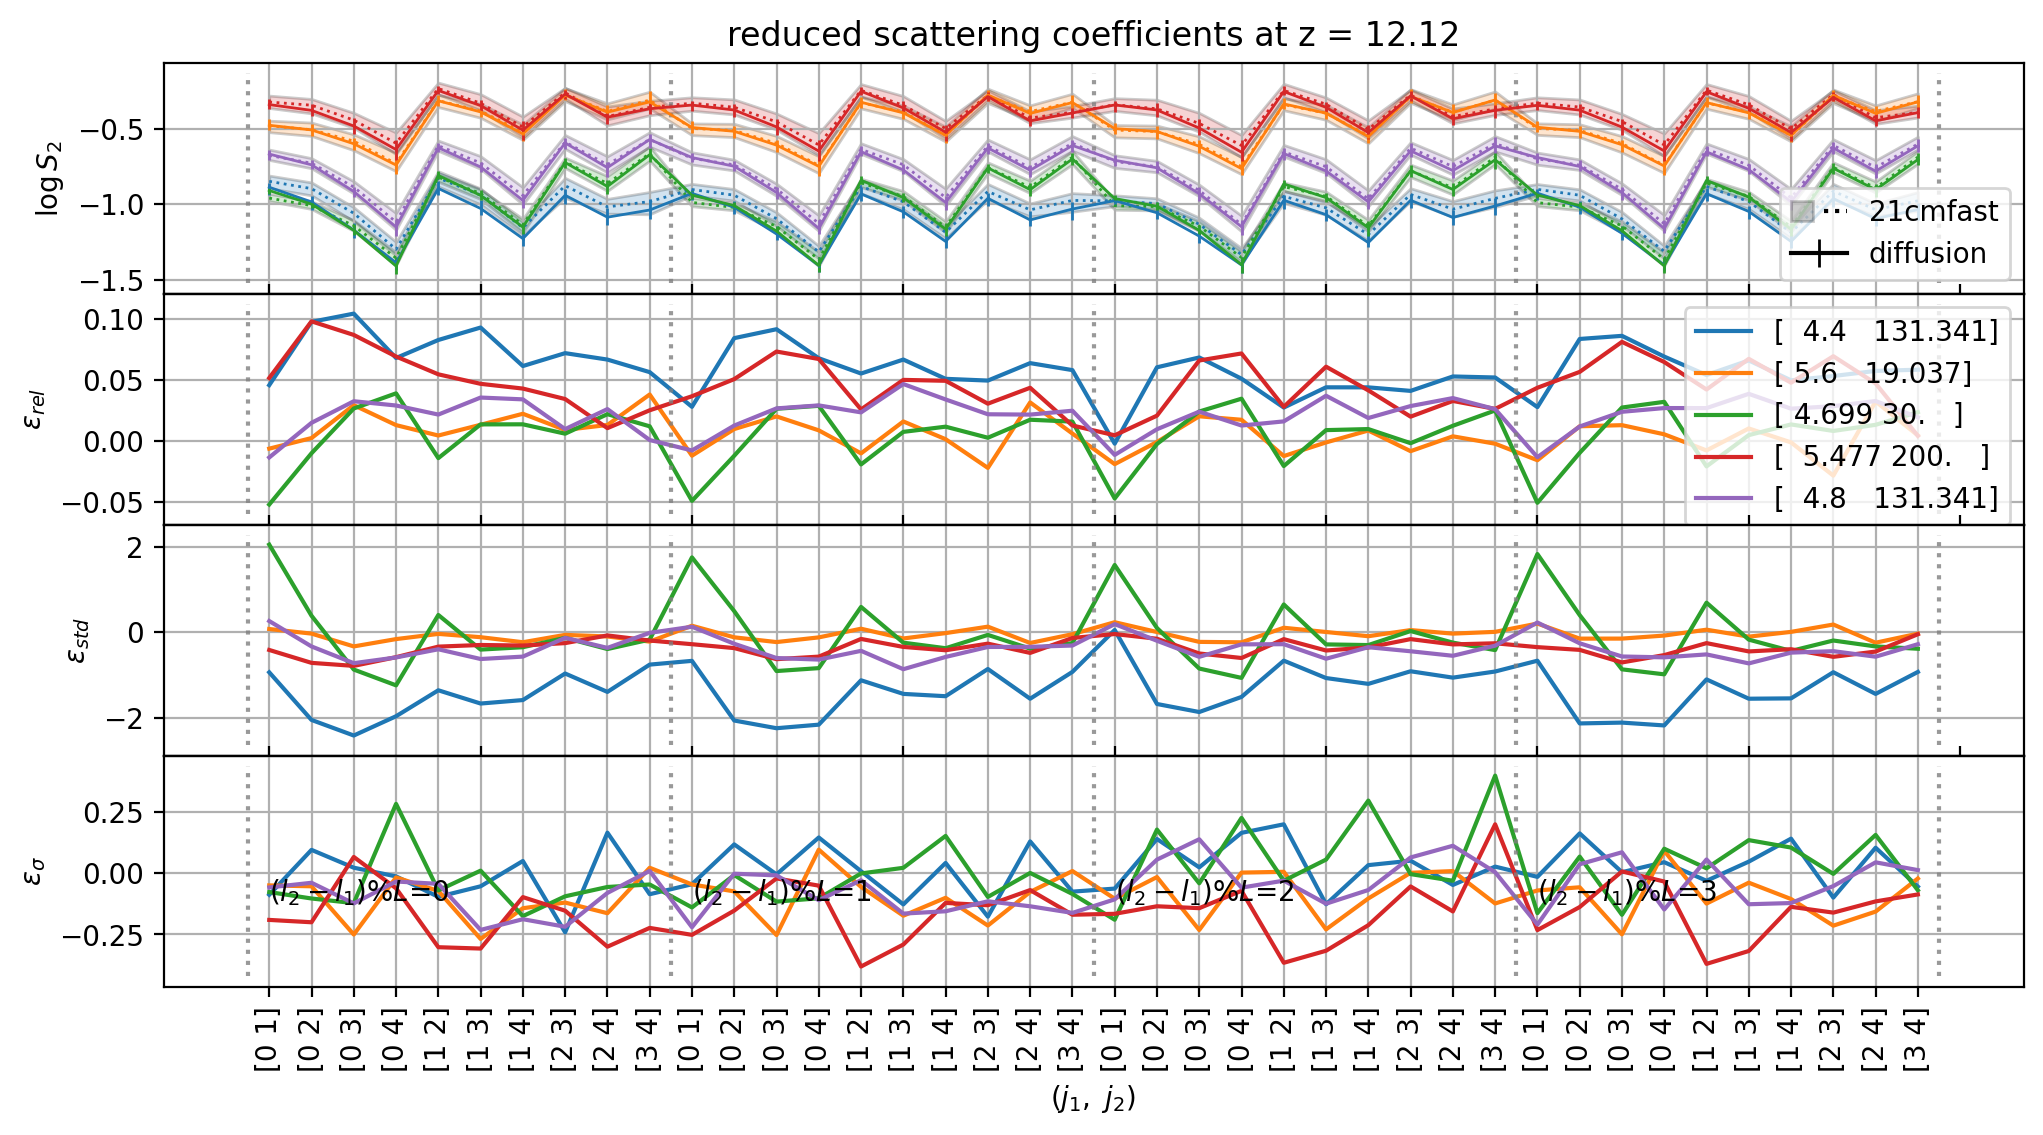

In [50]:
plot_scattering_transform_2(
    [
        # (x0,x0_ml),
        # (x1,x1_ml),
        # (x2,x2_ml),
        # (x3,x3_ml),
        # (x4,x4_ml),
        
        (x0[...,0],x0_ml[...,0]),
        (x1[...,0],x1_ml[...,0]),
        (x2[...,0],x2_ml[...,0]),
        (x3[...,0],x3_ml[...,0]),
        (x4[...,0],x4_ml[...,0]),
        
        # (x0[...,0],x0_ml),
        # (x1[...,0],x1_ml),
        # (x2[...,0],x2_ml),
        # (x3[...,0],x3_ml),
        # (x4[...,0],x4_ml),
        
        # (x0[:len(x0_ml),...,512:512+64],x0_ml[...,0,512:512+64]),
        # (x1[:len(x1_ml),...,512:512+64],x1_ml[...,0,512:512+64]),
        # (x2[:len(x2_ml),...,512:512+64],x2_ml[...,0,512:512+64]),
        # (x3[:len(x3_ml),...,512:512+64],x3_ml[...,0,512:512+64]),
        # (x4[:len(x4_ml),...,512:512+64],x4_ml[...,0,512:512+64]),
        
        # (x0[:len(x0_ml),...,0,512:512+64],x0_ml[...,0,512:512+64]),
        # (x1[:len(x1_ml),...,0,512:512+64],x1_ml[...,0,512:512+64]),
        # (x2[:len(x2_ml),...,0,512:512+64],x2_ml[...,0,512:512+64]),
        # (x3[:len(x3_ml),...,0,512:512+64],x3_ml[...,0,512:512+64]),
        # (x4[:len(x4_ml),...,0,512:512+64],x4_ml[...,0,512:512+64]),
        
        # (x0[:len(x0_ml),...,512:512+64],x0_ml[:64,...,512:512+64]),
        # (x1[:len(x1_ml),...,512:512+64],x1_ml[:64,...,512:512+64]),
        # (x2[:len(x2_ml),...,512:512+64],x2_ml[:64,...,512:512+64]),
        # (x3[:len(x3_ml),...,512:512+64],x3_ml[:64,...,512:512+64]),
        # (x4[:len(x4_ml),...,512:512+64],x4_ml[:64,...,512:512+64]),
        
        # (x0[:len(x0_ml),...,512:512+64],x0_ml[...,512:512+64]),
        # (x1[:len(x1_ml),...,512:512+64],x1_ml[...,512:512+64]),
        # (x2[:len(x2_ml),...,512:512+64],x2_ml[...,512:512+64]),
        # (x3[:len(x3_ml),...,512:512+64],x3_ml[...,512:512+64]),
        # (x4[:len(x4_ml),...,512:512+64],x4_ml[...,512:512+64]),
    ],
    params = [
        c0[0], 
        c1[0],
        c2[0], 
        c3[0], 
        c4[0],
    ],
    )